In [2]:
import re
import pandas as pd
import pickle
from yahoo_fin.stock_info import *
import numpy as np
import datetime
import itertools as it
import networkx as nx
import string
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from collections import defaultdict
import nimfa
import scipy.io
import math


## Let's delve into the three archetypical stock roles:

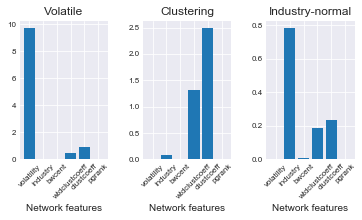

In [11]:
def plot_archetypes(composite_basis_matrix):  
    #Input composite_basis_matrix, a k x r matrix, where k is the number of
    #features input into nmf and r is the rank of the nmf.
    #Plots the three role archetypes as linear combination of features.

    fig=plt.figure()

    ## Role 1
    ax1=plt.subplot(131)
    
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax1.tick_params(axis='both', which='minor', labelsize=6)
    dataset = pd.DataFrame({'Feature1': features[:, 0], 'Feature2': features[:, 1], 'Feature3': features[:, 2]})
    y_pos=np.arange(np.size(features,0))
    bars=('volatility', 'industry', 'bwcent', 'wtdclustcoeff', 'clustcoeff', 'pgrank')
    feature1=dataset['Feature1']
    feature1=list(feature1)
    plt.bar(y_pos, feature1)
    plt.xticks(y_pos, bars, rotation='45')
    plt.title('Volatile')
    plt.xlabel('Network features')
    
    ## Role 2
    ax2=plt.subplot(132)
 
    ax2.tick_params(axis='both', which='major', labelsize=8)
    ax2.tick_params(axis='both', which='minor', labelsize=6)
    dataset = pd.DataFrame({'Feature1': features[:, 0], 'Feature2': features[:, 1], 'Feature3': features[:, 2]})
    y_pos=np.arange(np.size(features,0))
    bars=('volatility', 'industry', 'bwcent', 'wtdclustcoeff', 'clustcoeff', 'pgrank')
    feature1=dataset['Feature2']
    feature1=list(feature1)
    plt.bar(y_pos, feature1)
    plt.xticks(y_pos, bars, rotation='45')
    plt.title('Clustering')
    plt.xlabel('Network features')
    
    # Role 3
    ax3=plt.subplot(133)

    ax3.tick_params(axis='both', which='major', labelsize=8)
    ax3.tick_params(axis='both', which='minor', labelsize=6)
    dataset = pd.DataFrame({'Feature1': features[:, 0], 'Feature2': features[:, 1], 'Feature3': features[:, 2]})
    y_pos=np.arange(np.size(features,0))
    bars=('volatility', 'industry', 'bwcent', 'wtdclustcoeff', 'clustcoeff', 'pgrank')
    feature1=dataset['Feature3']
    feature1=list(feature1)
    plt.bar(y_pos, feature1)
    plt.xticks(y_pos, bars, rotation='45')
    plt.title('Industry-normal')
    plt.xlabel('Network features')

    fig.subplots_adjust(wspace=.4, bottom=.4)
    plt.savefig('../NMF_stocks/Plots/feature_archetypes.jpg', dpi=300)

    
##Upload composite features matrix
features=pd.read_csv('../NMF_stocks/Data/composite_features.csv', header=None)
features=features[1]
features=np.array(features)
features=np.reshape(features, (6,3))
plot_archetypes(features)

## The Volatile role:
These stocks tend to fluctuate widely in price.  Price changes do not track consistently with industry averages.  High-volatility stocks should be paired with low-volatile stocks in a portfolio.

## The Clustering role:
These stocks move consistently in tandem with a set of other stocks, although not necessarily others within its industry.  In future analysis I will examine how coherent these clusters appear across time.  Stocks that cluster together consistently over the long-term should not be paired together in a portfolio.

## The Industry-normal role:
These stocks' prices tend to move in tandem with industry averages. In future analysis I will examine which stocks tend to track with industry averages over the long term. No portfolio should contain two stocks that track closely with the same industry over the long-term.

## Which stocks were the most and least volatile over time?  Which clustered together?  Which tracked with their industries?

I take months for which basis matrices passed the cosine similarity test, meaning that they match well with the three roles described above.  I iterate through the basis matrices from these months to explore changes in the roles that particular stocks inhabit.

In [6]:
month_index=pd.read_csv('../NMF_stocks/Data/basis_matrices_worked.csv', header=None)
month_index=month_index[1]
date_df=pd.read_csv('../NMF_stocks/Data/dates.csv',header=None)
dates=[]
for ind in month_index:
    new=date_df[1][ind]
    dates.append(new)
        
def stock_roles(dates):
    
    max_vol=[]
    max_clus=[]
    max_ind=[]
    
    for date in dates:
        ## Get tickers list
        title='../NMF_stocks/Data/features_'+str(date)+'.pkl'
        infile = open(title,'rb')
        df = pickle.load(infile)
        infile.close()
        array = pd.DataFrame([([k] + v) for k, v in df.items()], columns=['ticker', 'growth', 'vol', 'industry', 'bwcent', 'wtdclustcoeff', 'clustcoeff', 'pgrank'])
        array_T=array.T
        tickers=array_T.iloc[0,:]
        V_title='../NMF_stocks/Data/V_'+str(date)+'.csv'
        V=pd.read_csv(V_title, header=None)
        V.columns=tickers
        # V is a m x n matrix, where each column represents one of n companies, and each row represents its 
        # coefficients for each of the m roles.
        V_T=V.T
        max2 = V_T.nlargest(2, 0)
        vol_list=list(max2.index.values)
        vol_mag=max2.iloc[:,0].values
        vol=list(zip(vol_list, vol_mag))
        for item in vol:
            max_vol.append((date, item))
        max2=V_T.nlargest(2, 1)
        clus_list=list(max2.index.values)
        clus_mag=max2.iloc[:,1].values
        clus=list(zip(clus_list, clus_mag))
        for item in clus:
            max_clus.append((date, item))
        max2=V_T.nlargest(2, 2)
        ind_list=list(max2.index.values)
        ind_mag=max2.iloc[:,2].values
        ind=list(zip(ind_list, ind_mag))
        for item in ind:
            max_ind.append((date, item))
    f = open('../NMF_stocks/Data/max_vol.pkl',"wb")
    pickle.dump(max_vol,f)
    f.close()
    f = open('../NMF_stocks/Data/max_clus.pkl',"wb")
    pickle.dump(max_clus,f)
    f.close()
    f = open('../NMF_stocks/Data/max_ind.pkl',"wb")
    pickle.dump(max_ind,f)
    f.close()
# stock_roles(dates)

## Let's plot individual companies' roles over time

I've identified the seven most volatile stocks in the dataset: Dupont (DD), Kraft Heinz (HNZ), Chesapeake Energy Corporation (CHK), Advanced Micro Devices (AMD), Akamai Technologies (AKAM), Science Applications International Corporation (SAI), and aTyr Pharmaceuticals (LIFE).

Let's plot changes in their roles coefficients over time.  As we can see, companies may inhabit different roles at different times.  At any time, as their coefficient for each role increases, they are more likely to inhabit that role; as it decreases, they are less likely to inhabit that role.

/Users/juliachuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/juliachuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/juliachuang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

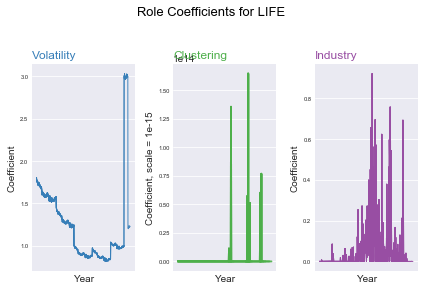

In [30]:
def get_vol(dates):
    top_vol=['DD', 'HNZ', 'CHK', 'AMD', 'AKAM', 'SAI', 'LIFE']
    max_vol=[]    
    for date in dates:
        ## Get tickers list
        title='../NMF_stocks/Data/features_'+str(date)+'.pkl'
        infile = open(title,'rb')
        df = pickle.load(infile)
        infile.close()
        array = pd.DataFrame([([k] + v) for k, v in df.items()], columns=['ticker', 'growth', 'vol', 'industry', 'bwcent', 'wtdclustcoeff', 'clustcoeff', 'pgrank'])
        array_T=array.T
        tickers=array_T.iloc[0,:]
        tickers=tickers.tolist()
        V_title='V_'+str(date)+'.csv'
        V=pd.read_csv(V_title, header=None)
        for ticker in top_vol:
            try:
                i1=tickers.index(str(ticker))
                vol1=V.iloc[0, i1]
                max_vol.append((date, ticker, vol1))
            except:
                ValueError
                pass
    df=pd.DataFrame(max_vol, columns=['Date', 'Ticker', 'Coefficient'])
    df.to_csv('../NMF_stocks/Data/max_vol.csv', header=True)

def vol_roles(dates, tickers):
    
    vol=[]
    clus=[]
    ind=[]
    
    for ticker in tickers:
        for date in dates:
            ## Get tickers list
            title='../NMF_stocks/Data/features_'+str(date)+'.pkl'
            infile = open(title,'rb')
            df = pickle.load(infile)
            infile.close()
            array = pd.DataFrame([([k] + v) for k, v in df.items()], columns=['ticker', 'growth', 'vol', 'industry', 'bwcent', 'wtdclustcoeff', 'clustcoeff', 'pgrank'])
            array_T=array.T
            tickers=array_T.iloc[0,:]
            V_title='../NMF_stocks/Data/V_'+str(date)+'.csv'
            V=pd.read_csv(V_title, header=None)
            V.columns=tickers
            # V is a mxn matrix, where each column represents one of n companies, and each row represents its 
            # coefficients for each of the m roles.
            try:
                d1=V.loc[0, ticker]
                vol.append(d1)
            except:
                ValueError
                pass
            try:
                d2=V.loc[1, ticker]
                clus.append(d2)
            except:
                ValueError
                pass
            try:
                d3=V.loc[2, ticker]
                ind.append(d3)
            except:
                ValueError
                pass
        df=pd.DataFrame(list(zip(vol, clus, ind)), columns=['Volatility', 'Clustering', 'Industry'])
        df.to_csv('../NMF_stocks/Data/'+str(ticker)+'.csv', header=True)
    
def plot_vols(tickers):
    for ticker in tickers:
        title='../NMF_stocks/Data/'+str(ticker)+'.csv'
        df=pd.read_csv(title, header=0)
        df.drop(['Unnamed: 0'],1, inplace=True)

        plt.style.use('seaborn-darkgrid')
 
        # create a color palette
        palette = plt.get_cmap('Set1')
        num=0
        for column in df:
            num+=1
            plt.subplot(1,3, num)
            if num==2:
                plt.plot(df[column]/1e-15, color=palette(num), linewidth=1.9, alpha=0.9)
                plt.ylabel('Coefficient, scale = 1e-15', fontsize=10)
                plt.xlabel('Year', fontsize=10)
                plt.yticks(size='xx-small')
                plt.xticks([])
                plt.tight_layout()
            else:
                plt.plot(df[column], color=palette(num), linewidth=1, alpha=0.9)
                plt.ylabel('Coefficient', fontsize=10)
                plt.xlabel('Year', fontsize=10)
                plt.yticks(size='xx-small')
                plt.xticks([])
            # Add title
            plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num) )
        plt.tight_layout()
        plt.subplots_adjust(top=.8)
        title='Role Coefficients for '+str(ticker)+' '
        plt.suptitle(title, fontsize=13, fontweight=0, color='black', y=1)
        plt.savefig('../NMF_stocks/Plots/Roles_over_time_'+str(ticker)+'.png', bbox_inches='tight', dpi=300)
    
#Get tickers
tickers=['DD', 'HNZ', 'CHK', 'AMD', 'AKAM', 'SAI', 'LIFE']
month_index=pd.read_csv('../NMF_stocks/Data/basis_matrices_worked.csv', header=None)
month_index=month_index[1]
#Get dates
date_df=pd.read_csv('../NMF_stocks/Data/dates.csv',header=None)
dates=[]
for ind in month_index:
    new=date_df[1][ind]
    dates.append(new)
    
##CALL FUNCTIONS
# get_vol(dates)
vol_roles(dates, tickers)
plot_vols(tickers)
